# Simulation of production line with defects - Training Via Configuration File

In this notebook we will train a Anomalib model using the Anomalib API and our own dataset. This notebook is also part of the Dobot series notebooks.

### Use case

Using the [Dobot Magician](https://www.dobot.cc/dobot-magician/product-overview.html) we could simulate a production line system. Imagine we have a cubes factory and they need to know when a defect piece appear in the process. We know very well what is the aspecto of the normal cubes. Defects are coming no often and we need to put those defect cubes out of the production line.

<img src="https://user-images.githubusercontent.com/10940214/174126337-b344bbdc-6343-4d85-93e8-0cb1bf39a4e3.png" alt="drawing" style="width:400px;"/>


| Class | Yellow cube | Red cube | Green cube | Inferencing using Anomalib
| --------------------------------------------------------------------------------------- | --------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ | --------------------------------------------------------------------------- | --------------------------------------------------------------------------- |
| Normal | <img src="https://user-images.githubusercontent.com/10940214/174083561-38eec918-efc2-4ceb-99b1-bbb4c91396b2.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083638-85ff889c-6222-4428-9c7d-9ad62bd15afe.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083707-364177d4-373b-4891-96ce-3e5ea923e440.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129305-03d9b71c-dfd9-492f-b42e-01c5c24171cc.jpg" alt="drawing" style="width:150px;"/> |
| Abnormal | <img src="https://user-images.githubusercontent.com/10940214/174083805-df0a0b03-58c7-4ba8-af50-fd94d3a13e58.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083873-22699523-22b4-4a55-a3da-6520095af8af.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174083944-38d5a6f4-f647-455b-ba4e-69482dfa3562.jpg" alt="drawing" style="width:150px;"/> | <img src="https://user-images.githubusercontent.com/10940214/174129253-f7a567d0-84f7-4050-8065-f00ba8bb973d.jpg" alt="drawing" style="width:150px;"/> | 

Using Anomalib we are expecting to see this result.

### Set up the working directory

In [1]:
from __future__ import annotations

import os
from pathlib import Path
from typing import Any

from git.repo import Repo

current_directory = Path.cwd()
if current_directory.name == "dobot":
    # On the assumption that, the notebook is located in
    #   ~/anomalib/notebooks/005_uses_cases/
    root_directory = current_directory.parent.parent.parent
elif current_directory.name == "anomalib":
    # This means that the notebook is run from the main anomalib directory.
    root_directory = current_directory
else:
    # Otherwise, we'll need to clone the anomalib repo to the `current_directory`
    repo = Repo.clone_from(url="https://github.com/openvinotoolkit/anomalib.git", to_path=current_directory)
    root_directory = current_directory / "anomalib"

os.chdir(root_directory)
print(root_directory)

folder_dataset_root = root_directory / "datasets" / "cubes"

C:\Users\pjram\OneDrive\Documents\GitHub\anomalib


## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer

from anomalib.config import get_configurable_parameters
from anomalib.data.utils import read_image
from anomalib.data import get_datamodule
from anomalib.deploy import OpenVINOInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks
from anomalib.data.folder import Folder, FolderDataset
from anomalib.data.utils import InputNormalizationMethod, get_transforms

c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\requests\__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


## Configuration - Via file

The config file contains the setup of different Anomalib modules, data manager, model manager, experiment manager and callback manager. We can modify the setup modifying the configuration file and also API.

## Model

Currently, there are **13** anomaly detection models available in `anomalib` library. Namely,

- [CFA](https://arxiv.org/abs/2206.04325)
- [CS-Flow](https://arxiv.org/abs/2110.02855v1)
- [CFlow](https://arxiv.org/pdf/2107.12571v1.pdf)
- [DFKDE](https://github.com/openvinotoolkit/anomalib/tree/main/anomalib/models/dfkde)
- [DFM](https://arxiv.org/pdf/1909.11786.pdf)
- [DRAEM](https://arxiv.org/abs/2108.07610)
- [FastFlow](https://arxiv.org/abs/2111.07677)
- [Ganomaly](https://arxiv.org/abs/1805.06725)
- [Padim](https://arxiv.org/pdf/2011.08785.pdf)
- [Patchcore](https://arxiv.org/pdf/2106.08265.pdf)
- [Reverse Distillation](https://arxiv.org/abs/2201.10703)
- [R-KDE](https://ieeexplore.ieee.org/document/8999287)
- [STFPM](https://arxiv.org/pdf/2103.04257.pdf)

In this tutorial, we'll be using Padim. Now, let's get their config paths from the respected folders.

In [3]:
MODEL = "padim"  # 'padim', 'cflow', 'stfpm', 'ganomaly', 'dfkde', 'patchcore'
CONFIG_PATH = root_directory / "notebooks/500_use_cases/dobot/cubes_config.yaml"
with open(file=CONFIG_PATH, mode="r", encoding="utf-8") as file:
    print(file.read())

# Replace the dataset configs with the following.
dataset:
  name: cubes
  format: folder
  path: ./datasets/cubes
  normal_dir: normal # name of the folder containing normal images.
  abnormal_dir: abnormal # name of the folder containing abnormal images.
  task: classification # classification or segmentation
  mask: null
  extension: null
  seed: 0
  normal_test_dir: null # optional
  extensions: null
  train_batch_size: 32
  eval_batch_size: 32
  num_workers: 8
  image_size: 256 # dimensions to which images are resized (mandatory)
  center_crop: null # dimensions to which images are center-cropped after resizing (optional)
  normalization: none # data distribution to which the images will be normalized: [none, imagenet]
  transform_config:
    train: null
    eval: null
  test_split_mode: from_dir # options: [from_dir, synthetic]
  test_split_ratio: 0.2 # fraction of train images held out testing (usage depends on test_split_mode)
  val_split_mode: same_as_test # options: [same_as_

We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/development/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with Padim implementation, which uses `./datasets/cubes` as the path to the dataset. We need to overwrite this after loading the config.

Now, the config file is updated as we want. We can now start model training with it. Here we will be using datamodule, model and callbacks to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using OpenVINO. Therefore we will set the export configuration to openvino so that anomalib would export the trained model to the openvino format.

In [4]:
# pass the config file to model, logger, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
config["dataset"]["path"] = "../../datasets/cubes"     # or wherever the Custom Dataset is stored.
print(config)

{'dataset': {'name': 'cubes', 'format': 'folder', 'path': '../../datasets/cubes', 'normal_dir': 'normal', 'abnormal_dir': 'abnormal', 'task': 'classification', 'mask': None, 'extension': None, 'seed': 0, 'normal_test_dir': None, 'extensions': None, 'train_batch_size': 32, 'eval_batch_size': 32, 'num_workers': 8, 'image_size': [256, 256], 'center_crop': None, 'normalization': 'none', 'transform_config': {'train': None, 'eval': None}, 'test_split_mode': 'from_dir', 'test_split_ratio': 0.2, 'val_split_mode': 'same_as_test', 'val_split_ratio': 0.5, 'tiling': {'apply': False, 'tile_size': None, 'stride': None, 'remove_border_count': 0, 'use_random_tiling': False, 'random_tile_count': 16}, 'mask_dir': None, 'root': './datasets/cubes'}, 'model': {'name': 'padim', 'backbone': 'resnet18', 'pre_trained': True, 'layers': ['layer1', 'layer2', 'layer3'], 'normalization_method': 'min_max', 'input_size': [256, 256]}, 'metrics': {'image': ['F1Score', 'AUROC'], 'pixel': ['F1Score', 'AUROC'], 'threshold

C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\anomalib\config\config.py:253: DeprecationWarning: mask will be deprecated in favor of mask_dir in config.dataset in a future release.
  warn(
C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\anomalib\config\config.py:260: DeprecationWarning: path will be deprecated in favor of root in config.dataset in a future release.
  warn(DeprecationWarning("path will be deprecated in favor of root in config.dataset in a future release."))
C:\Users\pjram\OneDrive\Documents\GitHub\anomalib\anomalib\config\config.py:275: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(


### Dataset: Cubes

Prepare your own dataset for normal and defect pieces.

In [5]:
datamodule = get_datamodule(config)
datamodule.setup()          # Downloads the dataset if it's not in the specified `root` directory
datamodule.prepare_data()   # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
data.keys()

dict_keys(['image_path', 'label', 'image'])

In [7]:
# Check image size
data["image"].shape

torch.Size([32, 3, 256, 256])

### Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it.

In [8]:
model = get_model(config)
callbacks = get_callbacks(config)

c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\torchmetrics\utilities\prints.py:36: DeprecationWarning: From v0.10 an `'Binary*'`, `'Multiclass*', `'Multilabel*'` version now exist of each classification metric. Moving forward we recommend using these versions. This base metric will still work as it did prior to v0.10 until v0.11. From v0.11 the `task` argument introduced in this metric will be required and the general order of arguments may change, such that this metric will just function as an single entrypoint to calling the three specialized versions.
  warnings.warn(*args, **kwargs)
c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)
FeatureExtractor is deprecated. Use TimmFeatureExtractor instead. Both FeatureExtractor and TimmFeatureExtractor wil

In [9]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
Missing logger folder: results\padim\cubes\run\lightning_logs
Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']
c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `ROC` will save all targets and predictions in buffer. For large dataset

Training: 0it [00:00, ?it/s]

c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\pytorch_lightning\loops\optimization\optimizer_loop.py:137: UserWarning: `training_step` returned `None`. If this was on purpose, ignore this warning...
  self.warning_cache.warn("`training_step` returned `None`. If this was on purpose, ignore this warning...")


Validation: 0it [00:00, ?it/s]

c:\intel\anomali_mig\anomalib_test_env\lib\site-packages\torchmetrics\utilities\prints.py:36: DeprecationWarning: `torchmetrics.functional.auc` has been move to `torchmetrics.utilities.compute` in v0.10 and will be removed in v0.11.
  warnings.warn(*args, **kwargs)


In [10]:
# Validation
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

Cannot perform pixel-level evaluation when task type is classification. Ignoring the following pixel-level metrics: ['F1Score', 'AUROC']


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC                  1.0
      image_F1Score                 1.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## OpenVINO Inference

Now that we trained and tested a model, we could check a single inference result using OpenVINO inferencer object. This will demonstrate how a trained model could be used for inference.

### Load a Test Image
Let's read an image from the test set and perform inference using OpenVINO inferencer.

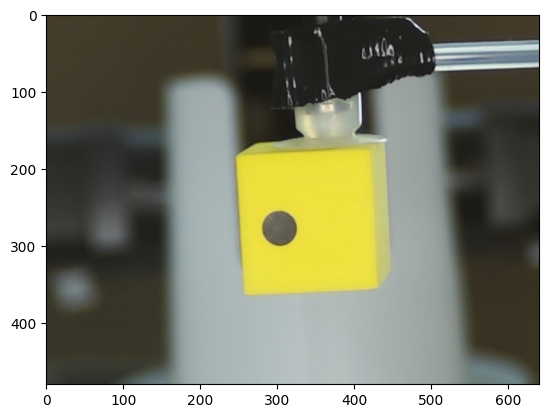

In [11]:
image_path = root_directory / "datasets/cubes/abnormal/input_20230210134059.jpg"
image = read_image(path="datasets/cubes/abnormal/input_20230210134059.jpg")
plt.imshow(image)

### Load the OpenVINO Model

By default, the output files are saved into `results` directory. Let's check where the OpenVINO model is stored.

In [12]:
output_path = Path(config["project"]["path"])
print(output_path)
openvino_model_path = output_path / "openvino" / "model.bin"
metadata_path = output_path / "openvino" / "meta_data.json"
print(openvino_model_path.exists(), metadata_path.exists())

results\padim\cubes\run
True True


In [13]:
inferencer = OpenVINOInferencer(
    config=CONFIG_PATH,  # Pass the config file to the inferencer.
    path=openvino_model_path,  # Path to the OpenVINO IR model.
    meta_data_path=metadata_path,  # Path to the metadata file.
    device="CPU",  # We would like to run it on an Intel CPU.
)

### Perform Inference
Predicting an image using OpenVINO inferencer is as simple as calling `predict` method.

In [14]:
print(image.shape)
predictions = inferencer.predict(image=image)

(480, 640, 3)


where `predictions` contain any relevant information regarding the task type. For example, predictions for a segmentation model could contain image, anomaly maps, predicted scores, labels or masks.
### Visualizing Inference Results

0.8582096863970176 True


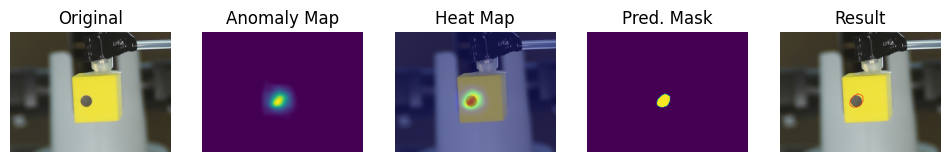

In [15]:
# create figure
fig = plt.figure(figsize=(12, 10))
  
# setting values to rows and column variables
rows = 1
columns = 5
  
# Adds a subplot at the 1st position
fig.add_subplot(rows, columns, 1)
  
# showing image
plt.imshow(predictions.image)
plt.axis('off')
plt.title("Original")
  
# Adds a subplot at the 2nd position
fig.add_subplot(rows, columns, 2)
  
# showing image
plt.imshow(predictions.anomaly_map)
plt.axis('off')
plt.title("Anomaly Map")
  
# Adds a subplot at the 3rd position
fig.add_subplot(rows, columns, 3)
  
# showing image
plt.imshow(predictions.heat_map)
plt.axis('off')
plt.title("Heat Map")
  
# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 4)
  
# showing image
plt.imshow(predictions.pred_mask)
plt.axis('off')
plt.title("Pred. Mask")

# Adds a subplot at the 4th position
fig.add_subplot(rows, columns, 5)
  
# showing image
plt.imshow(predictions.segmentations)
plt.axis('off')
plt.title("Result")

print(predictions.pred_score, predictions.pred_label)